In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.spatial.distance
import scipy.ndimage.filters
import copy
from matplotlib import animation
%matplotlib inline
import matplotlib as mpl
from pylab import cm


In [2]:
import matplotlib.font_manager as fm


font_dir = ['/scratch/wpc252/software/helvetica']
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)
# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
#print(font_names)

# Edit the font, font size, and axes width
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2


In [3]:
def potential(x, F):
    return 0.005*(x-5)**2*(x-20)**2 + F*x


def makarovp(xpoints, ypoints, a=1, b=0, barrier=1, d=0, s=0, l=9, w=1, vy=0.3, cy=1, Fx=0):
    xx, yy = np.meshgrid(xpoints,ypoints,sparse=True)
    potential = -np.log(np.exp(-(((a*yy-cy)**2-barrier)**2 + 0.5*(xx-s-yy)**2)) + b*np.exp((-(w*xx-l)**2-(yy-vy)**2)/0.5)) + Fx*xx + d*yy
    return potential #- potential.min()

def slip_rate_nm(force, k1s_0, xd, kbT = 2.478):
    force_kJ = force*(2.478/4.1)
    rate = k1s_0*np.exp(xd*force_kJ/kbT)
    tau = 1/rate
    return(rate, tau)

def slip_rate(force, k1s_0, xd, kbT = 0.596):
    force_kcal = force*0.0143929254
    rate = k1s_0*np.exp(xd*force_kcal/kbT)
    return rate

## Figure 1

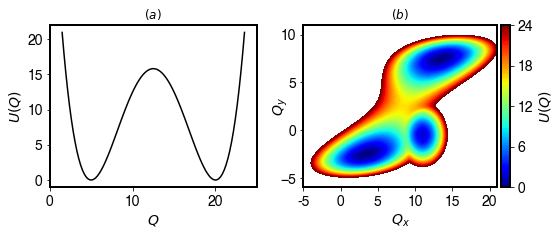

In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import font_manager
dist = np.linspace(1.5,23.5,100)
U = potential(dist, 0)
U_force = potential(dist,-2)
shift_U = U_force + 11
arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=2, shrink=0.5)
label_x = 20
label_y = 10
arrow_x = 20
arrow_y = 0
test_x_points = np.linspace(-5,21,100)
test_y_points = np.linspace(-5,10,75)
V = makarovp(test_x_points,test_y_points,a=0.4, b=0.2, barrier=4, d=0, s=6,l=11, w=1, vy=-0.5, cy=1, Fx=0)

fig, ax = plt.subplots(1,2, figsize=(8,3.5))
#for axis in ['top', 'bottom', 'left', 'right']:
 #   ax[0].spines[axis].set_linewidth(1.5)
  #  ax[1].spines[axis].set_linewidth(1.5)
ax[0].plot(dist, U, c='k')
ax[0].set_xlabel(r'$Q$', fontweight='bold')
ax[0].set_ylabel(r'$U(Q)$', fontweight='bold')
ax[0].set_xlim(0,25)
#ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_title(r"$(a)$", fontsize=12)
im1=ax[1].contourf(test_x_points,test_y_points, V, levels=np.linspace(0,24,100),cmap='jet')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb=fig.colorbar(im1, cax=cax, orientation='vertical', label=r'$U({Q})$')
cb_ax = cb.ax
#text = cb_ax.yaxis.label
#font = font_manager.FontProperties(size=14)
#text.set_font_properties(font)
#cb_ax.tick_params(labelsize=14)
cb.set_ticks(np.linspace(0,24,5))
ax[1].set_xlabel(r'$Q_x$', fontweight='bold')
ax[1].set_ylabel(r'$Q_y$', fontweight='bold', labelpad=-10)
ax[1].xaxis.set_major_locator(mpl.ticker.FixedLocator(np.linspace(-5, 20, 6)))
ax[1].set_xticklabels([int(i) for i in np.linspace(-5,20,6)])
ax[1].set_ylim(-6,11)      
ax[1].set_title(r"$(b)$", fontsize=12)
#ax[1].tick_params(axis='both', labelsize=14)
plt.tight_layout()
#fig.subplots_adjust(top=.93)
fig.savefig("../figures/slipbond/doublewell_and_triplewell.pdf", dpi=300)
plt.show()
plt.close()


## Figure 2

In [50]:
data = np.genfromtxt("../data/slipbond/Rates/rates_bars1.dat", dtype=float, comments='#') 
bell_params = np.genfromtxt("../data/slipbond/Rates/bell_params1.dat", dtype=float, comments='#') 
bell_dx = bell_params[0]
bell_k0 = np.exp(bell_params[1])
forces = data[:,0]
rates = data[:,1]
bars = data[:,3]

heightdat = np.genfromtxt("../data/slipbond/FES/barriervsH_fx.dat", dtype=float, comments='#') 
forces_h = heightdat[:,0]
height = heightdat[:,1]
dx_exp = heightdat[:,2]


dx_dat = np.genfromtxt("../data/slipbond/FES/double_well_analytical.dat", dtype=float, comments='#')
forces_dx = dx_dat[:,0]
height_dx = dx_dat[:,1]
dx_array = dx_dat[:,2]

infr_rates = rates
kb_T = 2.478
ln_infr_rates = np.log(infr_rates)
en_height_dx_beta = np.array(height)*bell_dx/kb_T
print(len(infr_rates), len(height), len(forces))


21 21 21


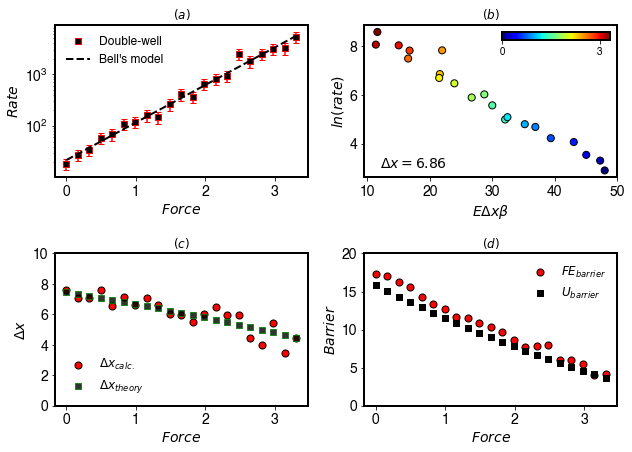

In [55]:
plt.rcParams['font.size'] = 14
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(2,2, figsize=(9,6.5))
ax[1,1].scatter(forces_h,height,c='r',edgecolors='k', label=r"$FE_{barrier}$",s=50)
ax[1,1].set_ylabel(r'$Barrier$', fontweight='bold', c='k')
ax[1,1].set_xlabel(r'$Force$', fontweight='bold')
ax[1,1].set_ylim(0,20)
ax[1,1].set_title(r"$(d)$", fontsize=12)
#ax2=ax[0,0].twinx()
ax[1,1].scatter(forces_dx, height_dx,c='k', marker='s',label=r"$U_{barrier}$",s=30)
#ax2.set_ylabel(r"$U_{barrier}$",c='k')
#ax2.set_ylim(0,20)
ax[1,1].legend(fontsize=12, loc='best', frameon=False)


theo_x = np.linspace(0.0,np.max(forces),100)
theo_y = slip_rate_nm(theo_x, bell_k0, bell_dx)[0]
ax[0,0].plot(forces, rates, c='k',marker='s',label='Double-well', linestyle='', mec='r')
ax[0,0].errorbar(forces, rates, bars, c='r', linestyle='', capsize=3)
ax[0,0].plot(theo_x, theo_y,  c='k', linestyle='--', linewidth=2, label="Bell's model")
ax[0,0].set_ylabel(r"$Rate$")
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel(r"$Force$")
ax[0,0].set_title(r"$(a)$", fontsize=12)
ax[0,0].legend(fontsize=12, loc='best', frameon=False)

ax[1,0].scatter(forces_h, dx_exp,c='r', edgecolors='k', s=50, label=r"$\Delta x_{calc.}$")
ax[1,0].set_ylabel(r'$\Delta x$', fontweight='bold')
ax[1,0].set_xlabel(r'$Force$', fontweight='bold')
ax[1,0].set_ylim(0,10)
ax[1,0].scatter(forces_dx, dx_array,c='k', marker='s', edgecolors='g', s=30, alpha=0.8, label=r"$\Delta x_{theory}$")
ax[1,0].set_ylim(0,10)
ax[1,0].legend(fontsize=12, loc='lower left', frameon=False)
ax[1,0].set_title(r"$(c)$", fontsize=12)

lab = "%2.2f"%(bell_dx)
ax[0,1].scatter(en_height_dx_beta,ln_infr_rates, c=forces, cmap='jet',edgecolors='k',s=50)
ax[0,1].set_ylabel(r'$ln(rate)$', fontweight='bold')
ax[0,1].set_xlabel(r'$E\Delta x\beta$', fontweight='bold')
ax[0,1].set_title(r"$(b)$", fontsize=12)
ax[0,1].text(12,3,f"$\Delta x={lab}$")
xticks = np.linspace(10,50,5)
ax[0,1].set_xticks(xticks)
cmap = plt.get_cmap("jet")
norm = plt.Normalize(min(forces), max(forces))
sm =  ScalarMappable(norm=norm, cmap=cmap)
#sm.set_array([])    

plt.tight_layout()
cbaxes = inset_axes(ax[0,1], width=1.5, height="5%")
cbar = fig.colorbar(sm, cax=cbaxes, ticks = [0.,3], orientation='horizontal')
cbar.ax.tick_params(labelsize=10) 
fig.savefig("../figures/slipbond/figure2.pdf", dpi=500)
plt.show()
plt.close()

## Fig 3

In [93]:
from AnalysisMetad2 import catch_params
data = np.genfromtxt("../data/catchbond/Rates/rates_bars1.dat", dtype=float, comments='#') 
force_list = data[:,0]
rates_c =  data[:,1]
catch = catch_params(force_list, 1/rates_c)
k1c_0 = catch[0]
x1c = catch[1]
k1s_0 = catch[2]
x1s = catch[3]
print(k1c_0, x1c, k1s_0, x1s)

fvsH = np.genfromtxt("../data/catchbond/FES/barrier_vs_force_x.dat", dtype=float, comments='#')
forces_h = fvsH[:,0]
height_x = fvsH[:,1]

fvsHy = np.genfromtxt("../data/catchbond/FES/barrier_vs_force_y.dat", dtype=float, comments='#')
forces_hy = fvsHy[:,0]
height_y = fvsHy[:,1]


5.126770786810978 0.7055299269311988 0.013704163466763787 1.6014311588025947


In [94]:
force_catch = data[:,0][1:]
rates_c = data[:,1][1:]
catch = catch_params(force_catch, 1/rates_c)
k1c_0 = catch[0]
x1c = catch[1]
k1s_0 = catch[2]
x1s = catch[3]
print(k1c_0, x1c, k1s_0, x1s)
filedat = open("../data/catchbond/Rates/catch_params.dat", 'w')
filedat.write("#%s\t%s\t%s\t%s\n"%("k1c_0","x1c","k1s_0", "x1s"))
filedat.write("%f\t%f\t%f\t%f\n"%(k1c_0, x1c, k1s_0, x1s))
filedat.close()

7.0018017541225515 1.242354649847353 0.16617421841880833 0.8594161829004556


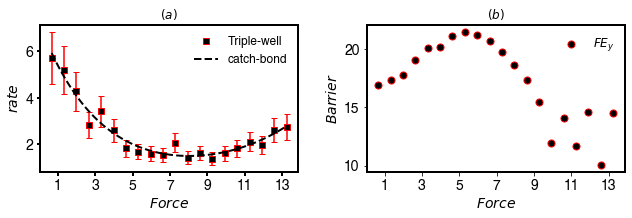

In [99]:
from AnalysisMetad2 import catch_rates_nm
%matplotlib inline
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2
model_name = 'Triple-well'
fig, ax = plt.subplots(1,2, figsize=(9,3.25))
theo_x = np.linspace(0.66, np.max(force_list), 100)
theo_y = catch_rates_nm(k1c_0,-x1c,k1s_0, x1s, theo_x)[0]
lab = F"{model_name}"
r_stds = data[:,3][1:]
ax[0].plot(force_catch, rates_c, c='k',marker='s',label=lab, linestyle='', mec='r')
ax[0].errorbar(force_catch, rates_c, r_stds, c='r', linestyle='', capsize=3)
ax[0].plot(theo_x, theo_y,  c='k', linestyle='--', linewidth=2, label="catch-bond")
ax[0].tick_params(axis='both', width=2)
ax[0].set_ylabel(r"$rate$")
ax[0].set_xticks(np.linspace(1,13,7))
ax[0].set_xlabel(r"$Force$")
ax[0].legend(fontsize=12, frameon=False)
ax[0].set_title(r"$(a)$", fontsize=12)

#ax[1].scatter(forces_h[:-1],height_x[:-1],c='r',edgecolors='k', label=r"$FE_x$",s=50)
ax[1].scatter(forces_hy[:-1],height_y[:-1],c='k',edgecolors='r',label=r"$FE_y$", s=50)
#ax[1].tick_params(axis='both', width=2)
ax[1].set_ylabel(r"$Barrier$")
ax[1].set_xlabel(r"$Force$")
ax[1].set_xticks(np.linspace(1,13,7))
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_title(r"$(b)$", fontsize=12)
fig.tight_layout()
fig.savefig("../figures/catchbond/Rates/figure3.pdf")
plt.show()
plt.close()

## Fig 4

In [70]:
data = np.genfromtxt("../data/cavity_ligand_free/Rates/Rigid_Free_rates_bars.dat", dtype=float, comments='#') 
bell_params = np.genfromtxt("../data/cavity_ligand_free/Rates/Rigid_Free_dx.dat", dtype=float, comments='#') 
bell_dx = bell_params[0]
bell_k0 = np.exp(bell_params[1])
forces = data[:,0]
rates = data[:,1]
bars = data[:,3]

heightdat = np.genfromtxt("../data/cavity_ligand_free/FES/Rigid_Free_Ebarrier_dx_min.dat", dtype=float, comments='#') 
forces_h = heightdat[:,0]
height = heightdat[:,1]
dx_exp = heightdat[:,2]-heightdat[:,3]


kb_T = 0.596
ln_infr_rates = np.log(rates)
en_height_dx_beta = np.array(height)*bell_dx/kb_T
print(len(ln_infr_rates), len(height), len(forces))

np.mean(dx_exp)

26 26 26


6.444025641320512

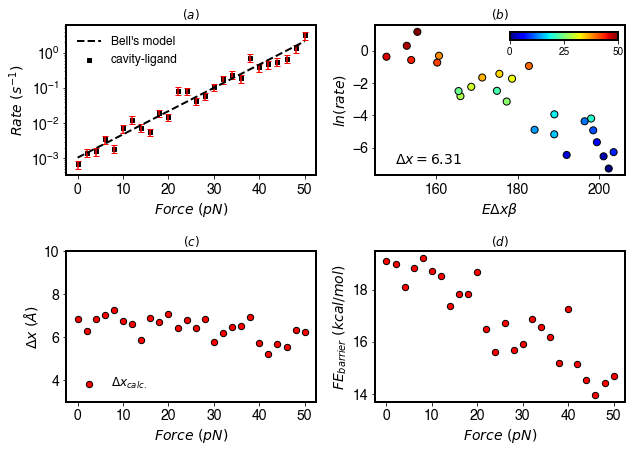

In [78]:
plt.rcParams['font.size'] = 14
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(2,2, figsize=(9,6.5))
ax[1,1].scatter(forces_h,height,c='r',edgecolors='k',s=40)
ax[1,1].set_ylabel(r'$FE_{barrier}\ (kcal/mol)$', fontweight='bold')
ax[1,1].set_xlabel(r'$Force\ (pN)$', fontweight='bold')
ax[1,1].set_xticks(np.linspace(0,50,6))
ax[1,1].set_title(r"$(d)$",fontsize=12)


theo_x = np.linspace(0.0,np.max(forces),100)
theo_y = slip_rate(theo_x, bell_k0, bell_dx)
ax[0,0].errorbar(forces, rates, bars, c='r', linestyle='', capsize=3)
ax[0,0].scatter(forces, rates, c='k',marker='s',label='cavity-ligand', s=10)
ax[0,0].plot(theo_x, theo_y,  c='k', linestyle='--', linewidth=2, label="Bell's model")
ax[0,0].set_ylabel(r"$Rate\ (s^{-1})$")
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel(r"$Force\ (pN)$")
ax[0,0].set_xticks(np.linspace(0,50,6))
ax[0,0].set_title(r"$(a)$",fontsize=12)
ax[0,0].legend(fontsize=12, loc='best', frameon=False)


ax[1,0].scatter(forces_h, dx_exp,c='r', edgecolors='k', s=40, label=r"$\Delta x_{calc.}$")
ax[1,0].set_ylabel(r'$\Delta x\ (\AA)$', fontweight='bold')
ax[1,0].set_xlabel(r'$Force\ (pN)$', fontweight='bold')
#ax[1,0].scatter(forces_dx, dx_array,c='k', marker='s', edgecolors='g', s=30, alpha=0.8, label=r"$\Delta x_{theory}$")
ax[1,0].legend(fontsize=12, loc='lower left', frameon=False)
ax[1,0].set_title(r"$(c)$",fontsize=12)
ax[1,0].set_ylim(3,10)
ax[1,0].set_xticks(np.linspace(0,50,6))

lab = "%2.2f"%(bell_dx)
ax[0,1].scatter(en_height_dx_beta,ln_infr_rates, c=forces, cmap='jet', edgecolors='k',s=50)
ax[0,1].set_ylabel(r'$ln(rate)$', fontweight='bold')
ax[0,1].set_xlabel(r'$E\Delta x\beta$', fontweight='bold')
ax[0,1].set_title(r"$(b)$",fontsize=12)
#xticks = np.linspace(10,50,5)
#ax[1,1].set_xticks(xticks)
cmap = plt.get_cmap("jet")
norm = plt.Normalize(min(forces), max(forces))
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

plt.tight_layout()
ax[0,1].text(150, -7, f"$\Delta x={lab}$")
cbaxes = inset_axes(ax[0,1], width=1.5, height="5%")
cbar = fig.colorbar(sm, cax=cbaxes, ticks = [0.,25,50], orientation='horizontal')
cbar.ax.tick_params(labelsize=10) 
fig.savefig("../figures/cavity_ligand_free/figure4.pdf")
plt.show()

In [80]:
data = np.genfromtxt("../data/sabiotin/Rates/rates_bars1_15ps.dat", dtype=float, comments='#') 
bell_params = np.genfromtxt("../data/sabiotin/Rates/bell_params_15ps.dat", dtype=float, comments='#') 
bell_dx = bell_params[0]
bell_k0 = bell_params[1]
forces = data[:,0]
rates = data[:,1]
bars = data[:,2]

rcvsFE = np.genfromtxt("../data/sabiotin/FES/FESvsrc.dat", dtype=float, comments='#') 
ubvsFE = np.genfromtxt("../data/sabiotin/FES/FESvsubdist2.dat", dtype=float, comments='#') 
rc = rcvsFE[:,0]
FE_rc = rcvsFE[:,1]

ub = ubvsFE[:,0]
FE_ub = ubvsFE[:,1]


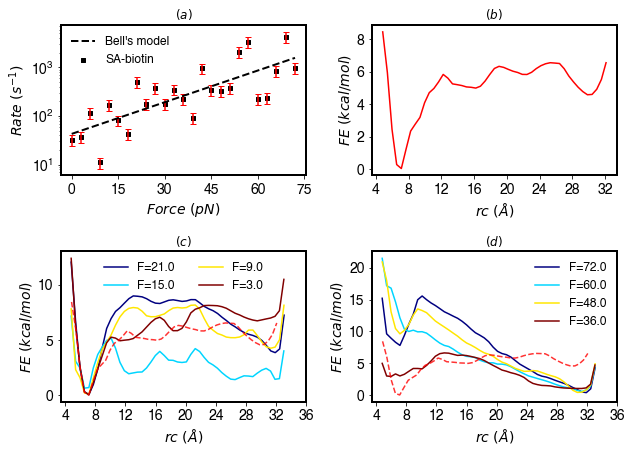

In [92]:
#plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(2,2, figsize=(9,6.5))
ax[0,1].plot(rc,FE_rc,c='r',label=r"$sgoop\ rc$")
#ax2=ax[0,0].twiny()
#ax2.plot(ub,FE_ub,c='k',label=r"$com\ distance$")
#ax2.set_xlabel(r'$ub. distance\ (\AA)$', fontweight='bold',c='k')
ax[0,1].set_ylabel(r'$FE\ (kcal/mol)$', fontweight='bold')
ax[0,1].set_xlabel(r'$rc\ (\AA)$', fontweight='bold', color='k')
ax[0,1].set_xticks(np.linspace(4,32,8))
ax[0,1].tick_params(axis='x', colors='k')
ax[0,1].set_title(r"$(b)$",fontsize=12)


from matplotlib import cm
viridis = cm.get_cmap('jet', 256)
keys = np.linspace(-72.0,-36.0,4)
newcolors = viridis(np.linspace(0,1,len(keys)))
for i,key in enumerate(keys):
    k = "%2.1f"%(key)
    fedata = np.genfromtxt(F"/home/wpc252/manuscripts/1/data/sabiotin/FES/FESvsrc{k}.dat",dtype=float, comments='#')
    ax[1,1].plot(fedata[:,0],fedata[:,1],color=newcolors[i],label=f"F={np.abs(key)}")
ax[1,1].plot(rc,FE_rc,c='r',linestyle='--', alpha=0.8)
ax[1,1].set_ylabel(r'$FE\ (kcal/mol)$', fontweight='bold')
ax[1,1].set_xlabel(r'$rc\ (\AA)$', fontweight='bold', color='k')
ax[1,1].set_xticks(np.linspace(4,36,9))
ax[1,1].tick_params(axis='x', colors='k')
ax[1,1].set_title(r"$(d)$",fontsize=12)
ax[1,1].legend(fontsize=12, loc='best', frameon=False)

keys = np.linspace(-21.0,-3.0,4)
newcolors = viridis(np.linspace(0,1,len(keys)))
for i,key in enumerate(keys):
    k = "%2.1f"%(key)
    fedata = np.genfromtxt(F"/home/wpc252/manuscripts/1/data/sabiotin/FES/FESvsrc{k}.dat",dtype=float, comments='#')
    ax[1,0].plot(fedata[:,0],fedata[:,1],color=newcolors[i],label=f"F={np.abs(key)}")

ax[1,0].plot(rc,FE_rc,c='r',linestyle='--', alpha=0.8)
ax[1,0].set_ylabel(r'$FE\ (kcal/mol)$', fontweight='bold')
ax[1,0].set_xlabel(r'$rc\ (\AA)$', fontweight='bold', color='k')
ax[1,0].set_xticks(np.linspace(4,36,9))
ax[1,0].tick_params(axis='x', colors='k')
ax[1,0].set_title(r"$(c)$",fontsize=12)
ax[1,0].legend(fontsize=12, ncol=2, loc='upper center', frameon=False)    
    
theo_x = np.linspace(0.0,np.max(forces),100)
theo_y = slip_rate(theo_x, bell_k0, bell_dx)
ax[0,0].errorbar(forces, rates, bars, c='r', linestyle='', capsize=3)
ax[0,0].scatter(forces, rates, c='k',marker='s',label='SA-biotin', s=10)
ax[0,0].plot(theo_x, theo_y,  c='k', linestyle='--', linewidth=2, label="Bell's model")
ax[0,0].set_ylabel(r"$Rate\ (s^{-1})$")
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel(r"$Force\ (pN)$")
ax[0,0].set_xticks(np.linspace(0,75,6))
ax[0,0].set_title(r"$(a)$",fontsize=12)
ax[0,0].legend(fontsize=12, loc='best', frameon=False)

plt.tight_layout()
fig.savefig("../figures/sabiotin/figure5.pdf")
plt.show()